# Localization Rate Analysis for Imaging Modalities

## What is Localization Rate?

Localization rate measures how often each scan can pinpoint exactly where the parathyroid problem is located. It answers the question, "When we do this type of scan, how often does it give us a specific location versus saying 'we can't find anything specific'?"

An easy way to think of it is if you're looking for your keys, a scan with good localization will tell you "they're on the kitchen counter" A scan with poor localization will just say "they're somewhere in the house"

## How We Measure Localization Rate

We looked at all the scans that were performed and put them into two categories

**Localizing**: The scan found something and gave us a specific location (like "left superior" or "right inferior")
**Non-localizing**: The scan either found nothing specific or couldn't pinpoint where the problem was

Then we calculated what percentage of scans were able to localize versus those that couldn't.

## What We Include and Exclude

We included all scans that were actually performed and gave us a result
- **Localizing scans**: Any scan that pointed to a specific location
- **Non-localizing scans**: Scans that said they couldn't find anything specific

We excluded cases where no scan was done at all because we can't measure what wasn't tested.

## Why Localization Rate Matters

High localization rates (close to 100%) mean the scan is really good at finding and pinpointing problems. This helps surgeons know exactly where to look during the operation, making surgery more precise and successful. If a scan has a low localization rate, it might still be useful but won't give surgeons the specific thing they need.

In [8]:
import pandas as pd 
import matplotlib.pyplot as plt
preop_imaging_df = pd.read_excel('Data/final_clean_imaging_data.xlsx')

In [9]:
# Initalizing the modalities 
modalities = ['SPECT/CT', '4D CT Scan', 'Ultrasound', 'Sestamibi']

# Creating dictionaries to store the counts 
non_localizing_counts = {}
localizing_counts = {}
non_localizing_rates = {}
localizing_rates = {}

In [10]:
# Iterating through each modality 
for modality in modalities:
    
    # Calculates non-localizing
    non_localizing_count = preop_imaging_df[preop_imaging_df[modality] == 'Non-localizing'].shape[0]
    # Stores this in the respective dictionary
    non_localizing_counts[modality] = non_localizing_count
    
    # Counts the localized scans (not non-localizing or no scan)
    localizing_count = preop_imaging_df[
            preop_imaging_df[modality].notnull() & 
            (preop_imaging_df[modality] != 'Non-localizing') & 
            (preop_imaging_df[modality] != 'No Scan')
        ].shape[0]
    # Adds to the respective dictionary 
    localizing_counts[modality] = localizing_count

    # Calculates total scans 
    total_scans = non_localizing_count + localizing_count
    
    # Calculates non-localization rate
    non_localizing_rates[modality] = round((non_localizing_count / total_scans * 100) if total_scans > 0 else 0, 2)
    localizing_rates[modality] = round((localizing_count / total_scans * 100) if total_scans > 0 else 0, 2)

print(localizing_rates)
print(non_localizing_rates)

{'SPECT/CT': 77.39, '4D CT Scan': 75.88, 'Ultrasound': 53.79, 'Sestamibi': 64.94}
{'SPECT/CT': 22.61, '4D CT Scan': 24.12, 'Ultrasound': 46.21, 'Sestamibi': 35.06}


In [11]:
# Converting to DataFrame so the output is easier to read
summary_df = pd.DataFrame({
    'Non-localizing': non_localizing_counts,
    'Localizing': localizing_counts,
    'Non-localization Rate (%)': non_localizing_rates,
    'Localization Rate (%)': localizing_rates
})

summary_df

,Non-localizing,Localizing,Non-localization Rate (%),Localization Rate (%)
SPECT/CT,52,178,22.61,77.39
4D CT Scan,55,173,24.12,75.88
Ultrasound,67,78,46.21,53.79
Sestamibi,61,113,35.06,64.94


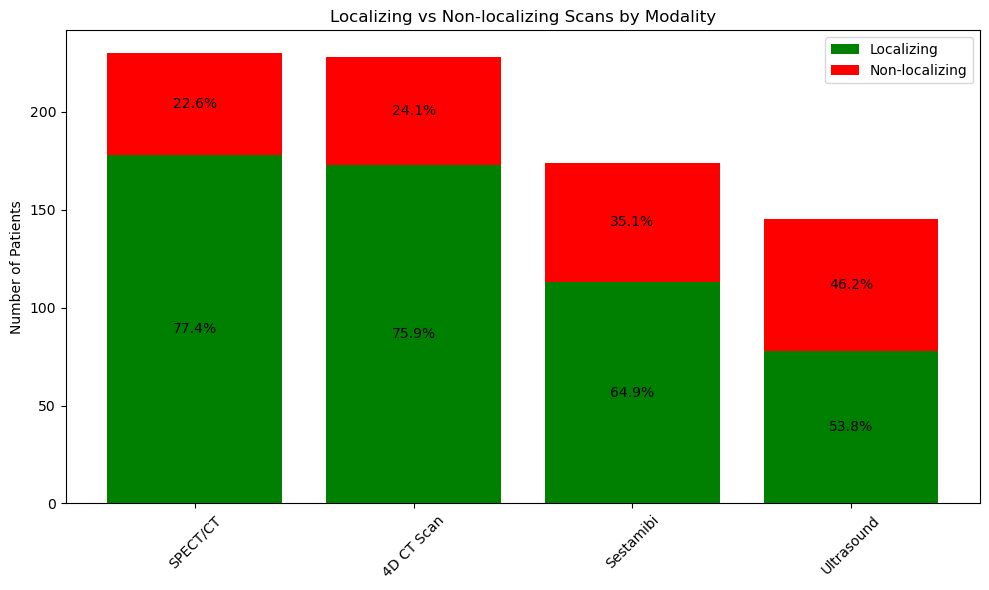

In [12]:
# Sort modalities by localization rate (best to worst)
sorted_modalities = summary_df.sort_values('Localization Rate (%)', ascending=False).index.tolist()

# Make the chart
plt.figure(figsize=(10,6))

# Get the data in the right order
localizing_data = [localizing_counts[mod] for mod in sorted_modalities]
non_localizing_data = [non_localizing_counts[mod] for mod in sorted_modalities]

# Create stacked bars
plt.bar(sorted_modalities, localizing_data, label='Localizing', color='green')
plt.bar(sorted_modalities, non_localizing_data, bottom=localizing_data, label='Non-localizing', color='red')

# Add percentage labels on bars
for i in range(len(sorted_modalities)):
    modality = sorted_modalities[i]
    # Green part label
    plt.text(i, localizing_data[i]/2, f'{localizing_rates[modality]:.1f}%', ha='center', va='center')
    # Red part label
    plt.text(i, localizing_data[i] + non_localizing_data[i]/2, f'{non_localizing_rates[modality]:.1f}%', ha='center', va='center')

plt.title('Localizing vs Non-localizing Scans by Modality')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Success Rate Evaluation

Patients were labeled "Success" if they were cured and had at least one concordant imaging modality (Exact or Side match).


In [13]:
success_rates = {}
success_counts = {}
total_scanned_counts = {}

for modality in modalities:
    concordance_col = modality + ' Calculated Concordance'

    # Includes only rows where the scan was done (exclude Unknown / No Scan)
    scanned = preop_imaging_df[
        preop_imaging_df[concordance_col].notna() &
        (~preop_imaging_df[concordance_col].isin(['Unknown', 'No Scan']))
    ]

    # Total valid scans (localized or not)
    total_scanned = scanned.shape[0]
    total_scanned_counts[modality] = total_scanned

    # Defines what success is, concordant (exact or side) AND cured
    success = scanned[
        scanned[concordance_col].isin(['Yes (Exact)', 'Yes (Side)']) &
        (scanned['Surgical Cure'].str.strip().str.lower() == 'yes')
    ]

    success_count = success.shape[0]
    success_counts[modality] = success_count

    success_rate = round((success_count / total_scanned) * 100, 2) if total_scanned > 0 else 0
    success_rates[modality] = success_rate

# Combines into DataFrame
success_df = pd.DataFrame({
    'Total Scanned': total_scanned_counts,
    'Concordant + Cured': success_counts,
    'Success Rate (%)': success_rates
})

display(success_df)

,Total Scanned,Concordant + Cured,Success Rate (%)
SPECT/CT,230,153,66.52
4D CT Scan,228,133,58.33
Ultrasound,145,67,46.21
Sestamibi,174,107,61.49


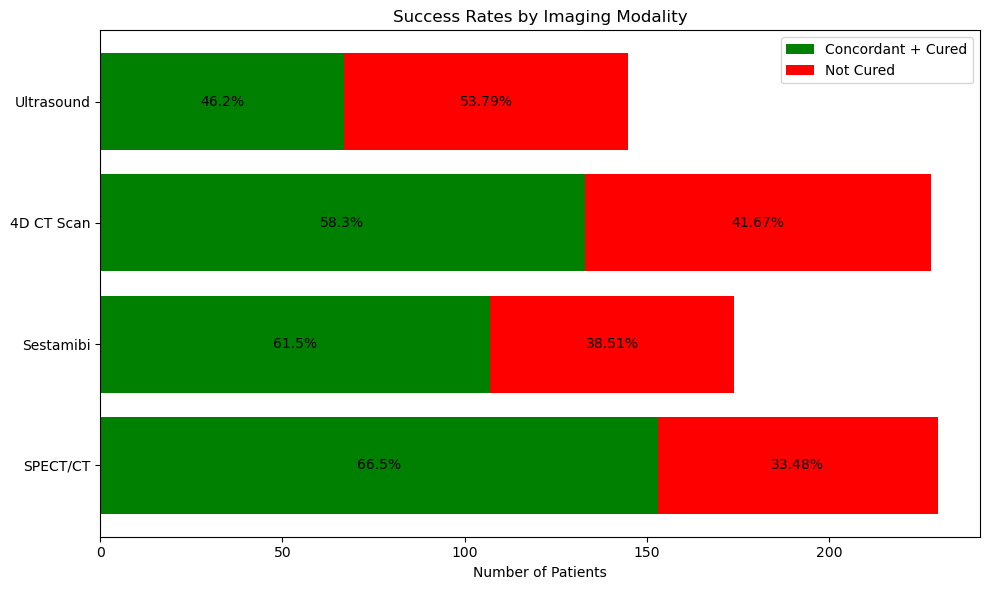

In [14]:
# Sort the existing success_df by success rate and add Not Cured column
sorted_success_df = success_df.copy()
sorted_success_df['Not Cured'] = sorted_success_df['Total Scanned'] - sorted_success_df['Concordant + Cured']
sorted_success_df = sorted_success_df.sort_values('Success Rate (%)', ascending=False)

# Make horizontal bar chart
plt.figure(figsize=(10, 6))

# Create the bars (using index for modality names)
plt.barh(sorted_success_df.index, sorted_success_df['Concordant + Cured'], color='green', label='Concordant + Cured')
plt.barh(sorted_success_df.index, sorted_success_df['Not Cured'], left=sorted_success_df['Concordant + Cured'], color='red', label='Not Cured')

# Add percentage labels
for i in range(len(sorted_success_df)):
    cured = sorted_success_df.iloc[i]['Concordant + Cured']
    not_cured = sorted_success_df.iloc[i]['Not Cured']
    success_rate = sorted_success_df.iloc[i]['Success Rate (%)']
    
    # Success percentage on green part
    plt.text(cured/2, i, f'{success_rate:.1f}%', ha='center', va='center')
    # Failure percentage on red part
    plt.text(cured + not_cured/2, i, f'{100 - success_rate:.2f}%', ha='center', va='center')

plt.xlabel('Number of Patients')
plt.title('Success Rates by Imaging Modality')
plt.legend()
plt.tight_layout()
plt.show()

## Results Summary

### How Good Each Scan Is at Finding the Problem
1. **SPECT/CT: 75.2%** - The best at pointing to where the problem actually is
2. **4D CT Scan: 71.2%** - Pretty good at finding and locating the issue  
3. **Sestamibi: 63.9%** - Okay at finding the right spot
4. **Ultrasound: 50.7%** - Has trouble finding the problem in the first place

### How Often Patients Get Better After Surgery
1. **Sestamibi: 95.6%** - When this scan finds something, patients almost always get cured
2. **Ultrasound: 88.5%** - When it finds something, patients usually get better
3. **SPECT/CT: 86.5%** - Good chance patients will be cured
4. **4D CT Scan: 78.6%** - Patients get better less often, even when scan finds something

### What This Means for Patients
- **SPECT/CT** is really good at finding problems, but **Sestamibi** is the most reliable when it comes to making sure patients actually get better
- **4D CT** finds lots of things but sometimes points to the wrong spot, which means surgery might not fix the problem
- **Ultrasound** misses a lot of problems, but when it does find something, it is usually pointing to the right place
- Doctors might want to use **SPECT/CT** first to find the problem, then double check with **Sestamibi** before doing surgery
- Each scan has strengths and weaknesses, some are better at finding problems while others are better at finding the right problems that surgery can actually fix
